The goal of this notebook is to use some classes and functions I wrote to compare the behaviour of polynomial least squares regression when using a monomial basis vs an orthogonal one. For the orthogonal polynomials we'll be using the Chebyshev polynomials. To start let's look at the first 5 monomials and the first 5 Chebyshev polynomials over the interval [-1, 1]

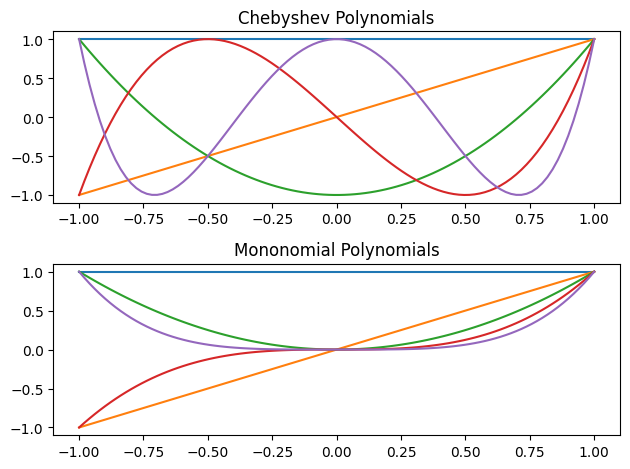

In [7]:
import matplotlib.pyplot as plt
import Poly_Regression as pr
import numpy as np
import polynomial_basis as pb
import numpy.polynomial.polynomial as p

c = pb.Chebyshev_Polynomials(5)
m = pb.monomials(5)

x = np.linspace(-1, 1, 100)
y1 = [p.polyval(x, a) for a in c]
y2 = [p.polyval(x, a) for a in m]

fig, axs = plt.subplots(2, 1)
for i in range(5):
    axs[0].plot(x, y1[i])
    axs[1].plot(x, y2[i])
axs[0].set_title('Chebyshev Polynomials')
axs[1].set_title('Mononomial Polynomials')
plt.tight_layout()

Notice how distinct the Chebyshev polynomials are compared to the monomials. This is the source of a lot of issues when using polynomials in spectral methods, using monomials in those methods can lead to "nearly singular" matricies that cause numerical issues.

For our testing we'll use each basis to do polynomial regression on some synthetic data. We'll start by comparing some exact solution methods then we'll move to comparing the performance when using iterative methods.

We'll first use NumPy's least squares function to find the least squares minimizers:

original coefficients: [-3 -1 -2 -3 -2 -1]

monomial coefficients: [-3.06663412 -1.24922545 -1.87854767 -1.35961687 -2.04672256 -2.61988768]

chebyshev coefficients: [-4.76541239 -3.66537575 -1.91787297 -1.01389702 -0.2508794  -0.1331649 ]

chebyshev converted to monomial: [-3.06663412 -1.24922545 -1.87854767 -1.35961687 -2.04672256 -2.61988768]

total difference between coefficients: 9.614531393253856e-14


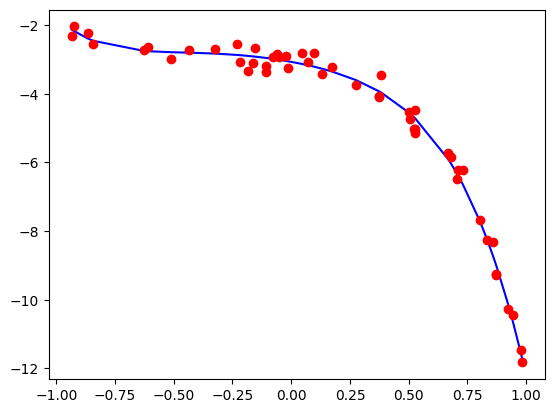

In [21]:
x = np.sort(np.random.uniform(-1, 1, 50))
a = np.random.randint(-3, 3, 6)
y = p.polyval(x, a) + np.random.normal(0, 1, 50)*0.2

model = pr.PolyLeastSquares(5)
model.fit(x, y)
c1 = model.get_coefficients()

model.basis = 'chebyshev'
model.fit(x, y)
c2 = model.get_coefficients()

print('original coefficients:', a)
print('\nmonomial coefficients:', c1)
print('\nchebyshev coefficients:', model.c)
print('\nchebyshev converted to monomial:', c2)
print('\ntotal difference between coefficients:',np.sum(np.abs(c1 - c2)))
plt.plot(x, model.predict(x), 'b', x, y, 'ro')

The get_coefficients() function used above multiplies through the computed coefficients and adds the polynomials together to give us the monomial coefficients. We see that when using NumPy's built in function there is virtually no difference between the coefficients. That makes sense since in both cases we're using a 5th degree polynomial. Changing basis should have no effect on the exact solution since it's essentially just a change of coordinates, in the same way that picking different directions for the x and y axis in a physics problem doesn't actually change the movement of the elements in the system.

For the next test we'll try usingthe so called "normal equations" where we multiply each side of the overdetermined system of linear equations by the transpose of the data matrix. This method provides the same least squares solution as the QR decomposition used in the NumPy least squares function but the normal equations are generally viewed as a worse solution technique because they require many more floating point operations to reach a solution. 

In [37]:
x = np.sort(np.random.uniform(-2, 2, 100))
a = np.random.randint(-5, 5, 6)
y = p.polyval(x, a) + np.random.normal(0, 1, 100)*0.2

model = pr.PolyLeastSquares(5)
model.fit(x, y)
c1 = model.get_coefficients()

model.basis = 'chebyshev'
model.fit(x, y)
c2 = model.get_coefficients()

print('original coefficients:', a)
print('\nmonomial coefficients:', c1)
print('\nchebyshev converted to monomial:', c2)
print('\ntotal difference between coefficients:',np.sum(np.abs(c1 - c2)))

original coefficients: [-1  1  4  2  4 -4]

monomial coefficients: [-0.93318346  1.07829965  3.90371232  1.95813261  4.01746046 -3.99628665]

chebyshev converted to monomial: [-0.93318346  1.07829965  3.90371232  1.95813261  4.01746046 -3.99628665]

total difference between coefficients: 1.816324868286756e-13


Again we see virtually no difference, this 

Residuals for monomial basis: [1.7290437611513354, 1.4571683820939823, 2.8562201515728063, 5.007823918455911]
Residuals for Chebyshev basis: [0.8214916853672222, 0.857073830280739, 2.174997174716195, 1.5858703279971178]


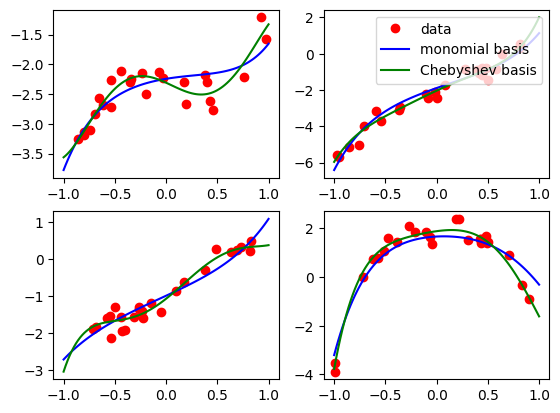

In [24]:
l = -1
r = 1
n = 25
d = 5
m = 4
diff = []
x = []
y = []
y1 = []
y2 = []
r1 = []
r2 = []
res1 = []
res2 = []
z = np.linspace(l, r, 100)

for i in range(4):
    a = np.random.randint(-3, 3, d)
    x.append(np.random.uniform(l, r, n))
    y.append(np.polyval(a, x[i]) + np.random.normal(0, 1, n)*0.25)

    model = pr.PolyLeastSquares(degree=d, basis='monomial'
                                , learning_rate=1e-3, max_iterations=10000, tol=0.0)
    model.fit(x[i], y[i], method='gd')
    y1.append(model.predict(z))
    r1.append(model.predict(x[i]))
    res1.append(np.linalg.norm(r1[i] - y[i])**2)

    model.basis = 'chebyshev'
    model.fit(x[i], y[i], method='gd')
    y2.append(model.predict(z))
    r2.append(model.predict(x[i]))
    res2.append(np.linalg.norm(r2[i] - y[i])**2)


print('Residuals for monomial basis:', res1)
print('Residuals for Chebyshev basis:', res2)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x[0], y[0],'ro', z, y1[0], 'b', z, y2[0], 'g')
axs[1, 0].plot(x[1], y[1], 'ro', z, y1[1], 'b', z, y2[1], 'g')
axs[0, 1].plot(x[2], y[2], 'ro', label='data')
axs[0, 1].plot(z, y1[2], 'b', label='monomial basis')
axs[0, 1].plot(z, y2[2], 'g', label='Chebyshev basis')
axs[1, 1].plot(x[3], y[3], 'ro', z, y1[3], 'b', z, y2[3], 'g')
axs[0,1].legend(loc='upper right')
plt.show()

Even though we ran both methods for the same number of sets we see that the Chebyshev method consistently reached a lower sum of square residuals. We can also see this very clearly in the plots, the green lines follow each data set much more closely. This makes sense since it's easier to move when we have an orthogonal basis, since the monomials are each very similar to eachother it's harder to move towards the true least squares solution. Think about two dimensions if your basis consisted of the vectors [1, 0] and [1, 0.001], it's difficult to move from [0, 0] to [0, 1] with those basis vectors.